## Initialisations

In [ ]:
# initialisations
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel
import random
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import os
import warnings
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn import tree 
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [ ]:
sns.set(
    palette="Paired",
    #style='whitegrid',
    color_codes=True,
    rc={"figure.figsize": (12,8)},
)

In [ ]:
url='https://drive.google.com/file/d/1kT70XbuamwT68SnK60My4ff08Y03Ce-t/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
adult_df = pd.read_csv(url)

## Preprocessing

In [ ]:
adult_df = adult_df.drop(columns="educational-num")

In [ ]:
adult_df = adult_df.rename(columns={"marital-status": "marital_status", "capital-gain": "capital_gain", "capital-loss": "capital_loss", "hours-per-week": "hours_per_week", "native-country": "native_country"})

In [ ]:
for col in adult_df:
    adult_df = adult_df[adult_df[col] != '?']

In [ ]:
for col in adult_df:
    adult_df = adult_df[adult_df[col] != 'Other']

In [ ]:
for col in adult_df:
    adult_df = adult_df[adult_df[col] != 'Other-relative']

In [ ]:
for col in adult_df:
    adult_df = adult_df[adult_df[col] != 'Other-service']

## Label Encoder

In [ ]:
le = LabelEncoder()
adult_df.workclass = le.fit_transform(adult_df.workclass)
adult_df.education = le.fit_transform(adult_df.education)
adult_df.marital_status = le.fit_transform(adult_df.marital_status)
adult_df.occupation = le.fit_transform(adult_df.occupation)
adult_df.relationship = le.fit_transform(adult_df.relationship)
adult_df.race = le.fit_transform(adult_df.race)
adult_df.gender = le.fit_transform(adult_df.gender)
adult_df.native_country = le.fit_transform(adult_df.native_country)
adult_df.income = le.fit_transform(adult_df.income)

## Partitioning

In [ ]:
# partition the husband subgroup from the rest
adult_df_husband = adult_df.copy()
adult_df_husband = adult_df_husband[adult_df_husband['relationship'] == 0]
adult_df_husband.groupby('income',sort=False).size()

income
0    9441
1    8375
dtype: int64

In [ ]:
# sample the partition
adult_df_husband = adult_df_husband.groupby('income', group_keys=False).apply(lambda x: x.sample(8375, random_state=64))

In [ ]:
# partition the not in family subgroup from the rest
adult_df_notinfamily = adult_df.copy()
adult_df_notinfamily = adult_df_notinfamily[adult_df_notinfamily['relationship'] == 1]
adult_df_notinfamily.groupby('income',sort=False).size()

income
0    8998
1    1194
dtype: int64

In [ ]:
# sample the partition
adult_df_notinfamily = adult_df_notinfamily.groupby('income', group_keys=False).apply(lambda x: x.sample(1194, random_state=64))

In [ ]:
# partition the own child subgroup from the rest
adult_df_ownchild = adult_df.copy()
adult_df_ownchild = adult_df_ownchild[adult_df_ownchild['relationship'] == 2]
adult_df_ownchild.groupby('income',sort=False).size()

income
0    5200
1     100
dtype: int64

In [ ]:
# sample the partition
adult_df_ownchild = adult_df_ownchild.groupby('income', group_keys=False).apply(lambda x: x.sample(100, random_state=64))

In [ ]:
# partition the unmarried subgroup from the rest
adult_df_unmarried = adult_df.copy()
adult_df_unmarried = adult_df_unmarried[adult_df_unmarried['relationship'] == 3]
adult_df_unmarried.groupby('income',sort=False).size()

income
0    3644
1     287
dtype: int64

In [ ]:
# sample the partition
adult_df_unmarried = adult_df_unmarried.groupby('income', group_keys=False).apply(lambda x: x.sample(287, random_state=64))

In [ ]:
# partition the wife subgroup from the rest
adult_df_wife = adult_df.copy()
adult_df_wife = adult_df_wife[adult_df_wife['relationship'] == 4]
adult_df_wife.groupby('income',sort=False).size()

income
0    853
1    964
dtype: int64

In [ ]:
# sample the partition
adult_df_wife = adult_df_wife.groupby('income', group_keys=False).apply(lambda x: x.sample(853, random_state=64))

## Husband Only Decision Model

In [ ]:
X = adult_df_husband.drop('income',axis=1)
y = adult_df_husband[['income']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(11167, 13)
Test data shape:(5583, 13)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
accuracy_score(y_test,pred)

0.677771807272076

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 0.05, 'random_state': 0, 'splitter': 'best'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='gini',
                                   min_samples_split=0.05,
                                   max_depth=None,
                                   max_features = None,
                                   min_samples_leaf=1,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(min_samples_split=0.05, random_state=0)

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
husband_accuracy = accuracy_score(y_test,pred)

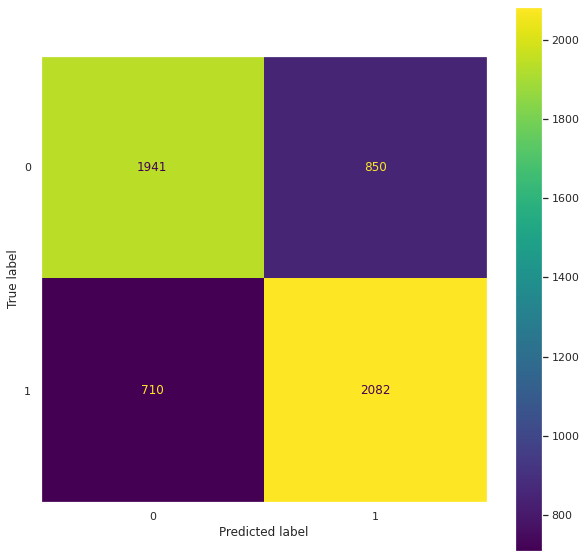

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

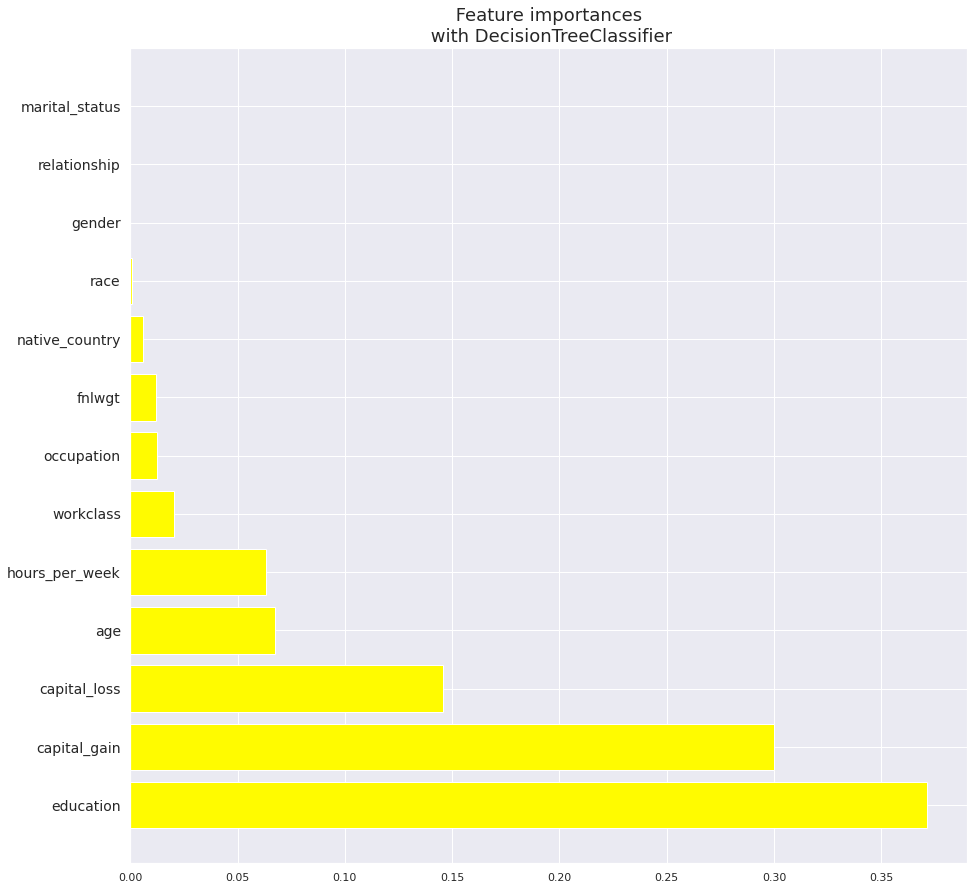

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = adult_df_husband.drop('income', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## Not in Family Only Decision Model

In [ ]:
X = adult_df_notinfamily.drop('income',axis=1)
y = adult_df_notinfamily[['income']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(1592, 13)
Test data shape:(796, 13)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
accuracy_score(y_test,pred)

0.7236180904522613

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 0.03, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'best'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='gini',
                                   min_samples_split=2,
                                   max_depth=10,
                                   max_features = None,
                                   min_samples_leaf=0.03,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=0.03, random_state=0)

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
notinfamily_accuracy = accuracy_score(y_test,pred)

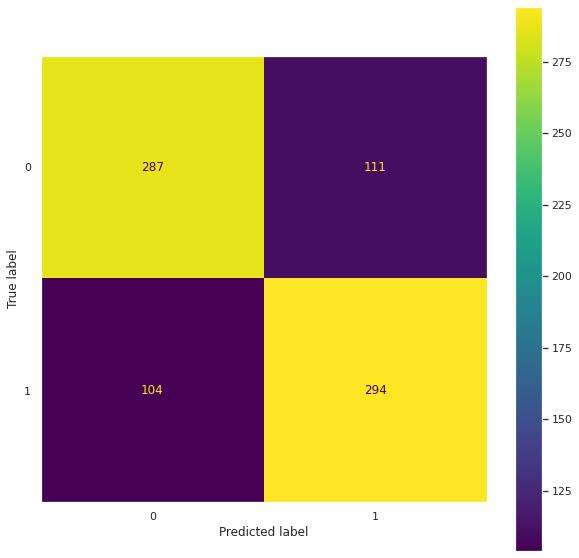

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

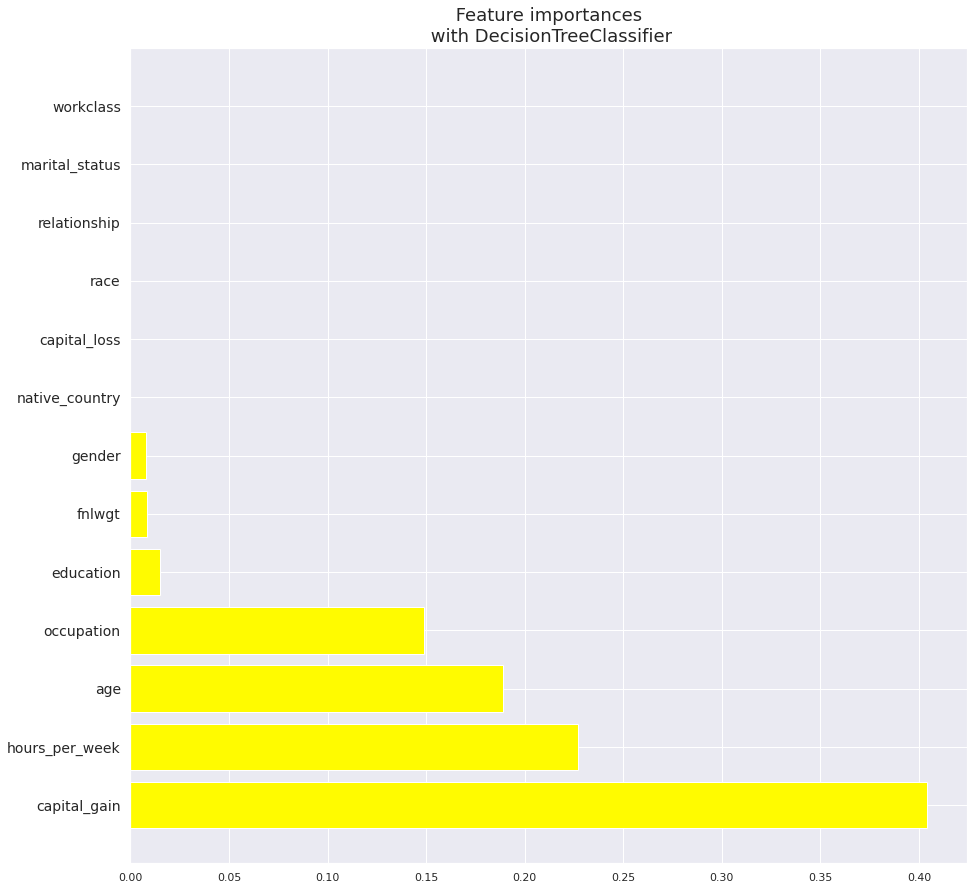

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = adult_df_notinfamily.drop('income', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## Own Child Only Decision Model

In [ ]:
X = adult_df_ownchild.drop('income',axis=1)
y = adult_df_ownchild[['income']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(134, 13)
Test data shape:(66, 13)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
accuracy_score(y_test,pred)

0.7272727272727273

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'best'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='entropy',
                                   min_samples_split=2,
                                   max_depth=4,
                                   max_features = None,
                                   min_samples_leaf=1,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
ownchild_accuracy = accuracy_score(y_test,pred)

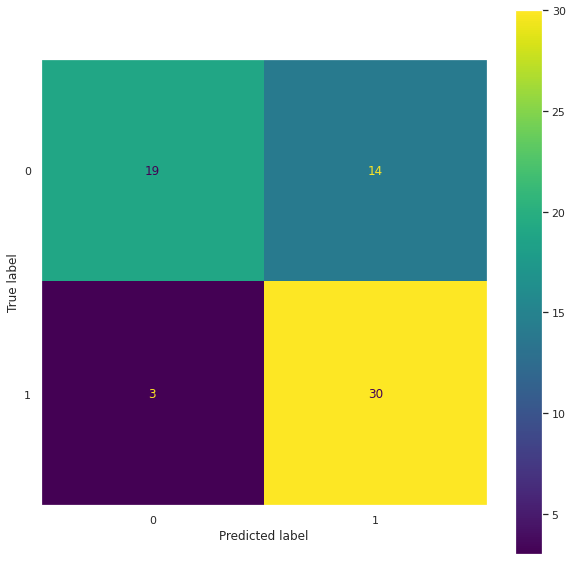

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

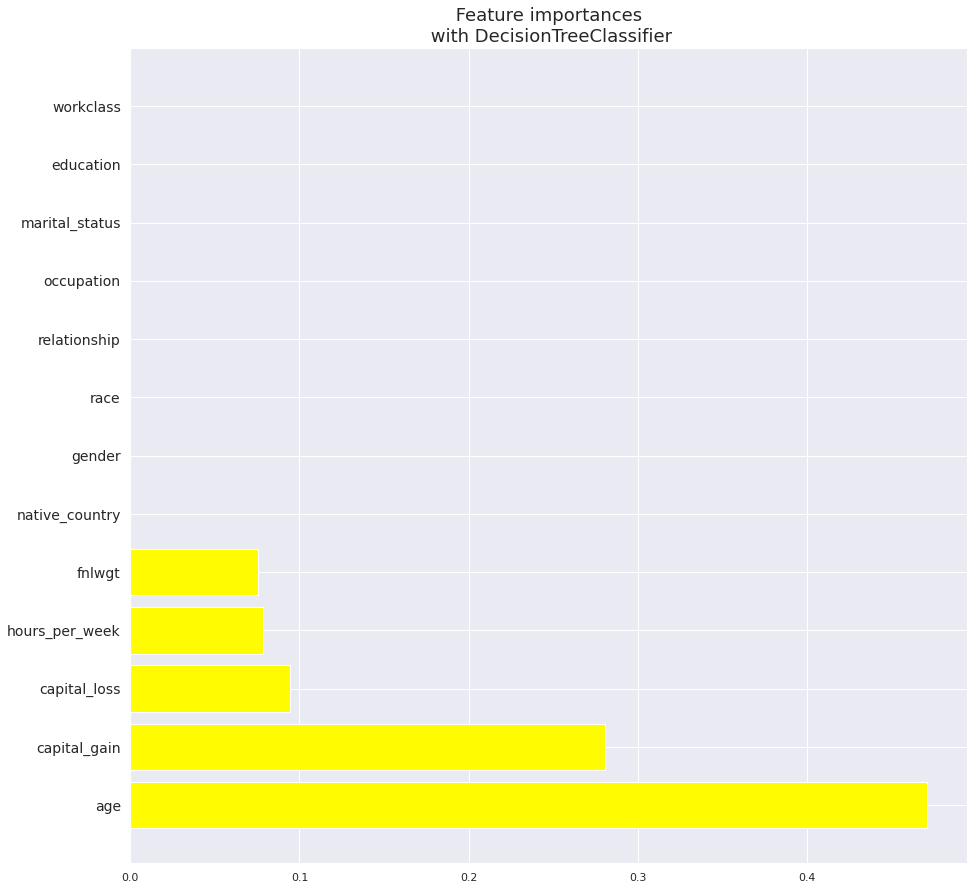

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = adult_df_ownchild.drop('income', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## Unmarried Only Decision Model

In [ ]:
X = adult_df_unmarried.drop('income',axis=1)
y = adult_df_unmarried[['income']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(383, 13)
Test data shape:(191, 13)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
accuracy_score(y_test,pred)

0.6910994764397905

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 0.05, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'best'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='entropy',
                                   min_samples_split=2,
                                   max_depth=6,
                                   max_features = None,
                                   min_samples_leaf=0.05,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=0.05,
                       random_state=0)

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
unmarried_accuracy = accuracy_score(y_test,pred)

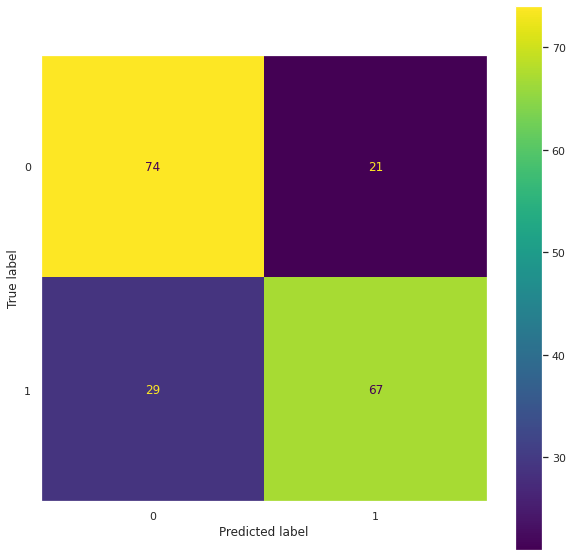

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

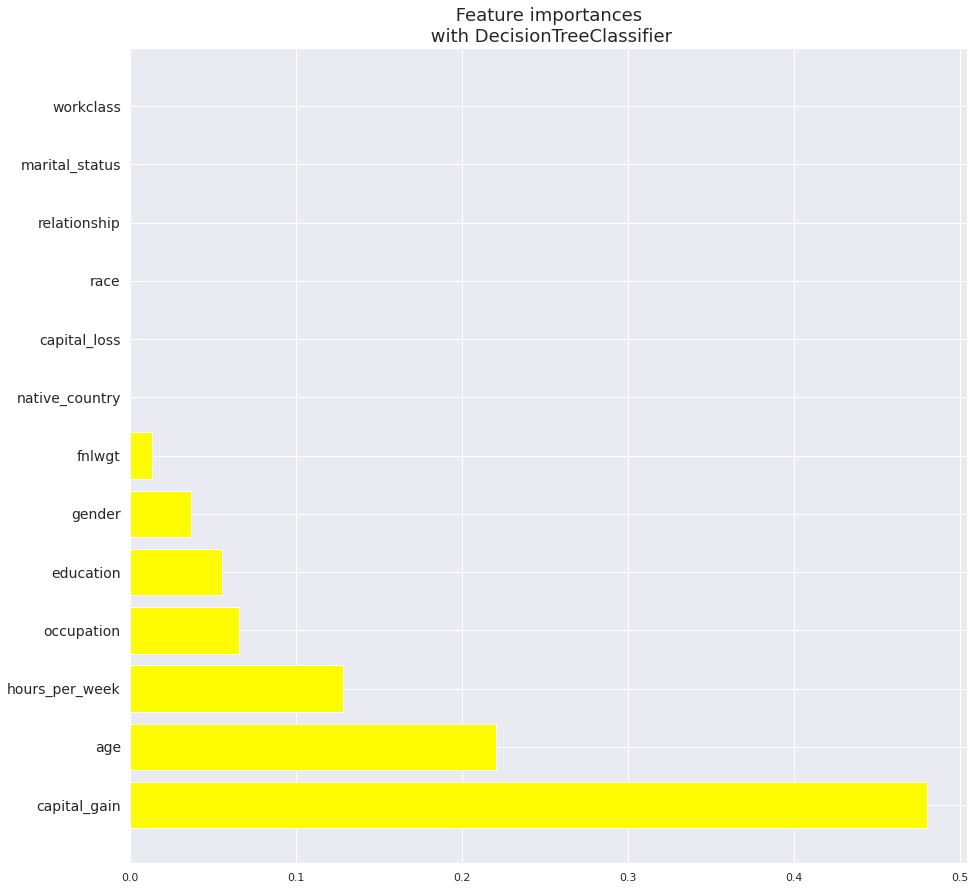

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = adult_df_unmarried.drop('income', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## Wife Only Decision Model

In [ ]:
X = adult_df_wife.drop('income',axis=1)
y = adult_df_wife[['income']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(1138, 13)
Test data shape:(568, 13)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
accuracy_score(y_test,pred)

0.6390845070422535

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 0.03, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'best'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='gini',
                                   min_samples_split=2,
                                   max_depth=8,
                                   max_features = None,
                                   min_samples_leaf=0.03,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=0.03, random_state=0)

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
wife_accuracy = accuracy_score(y_test,pred)

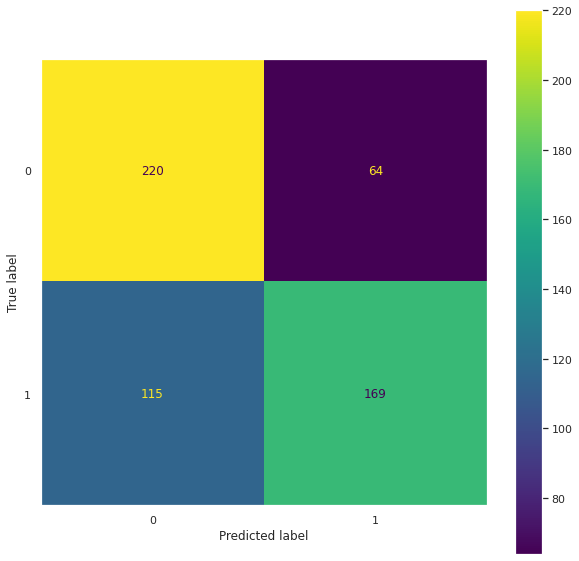

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

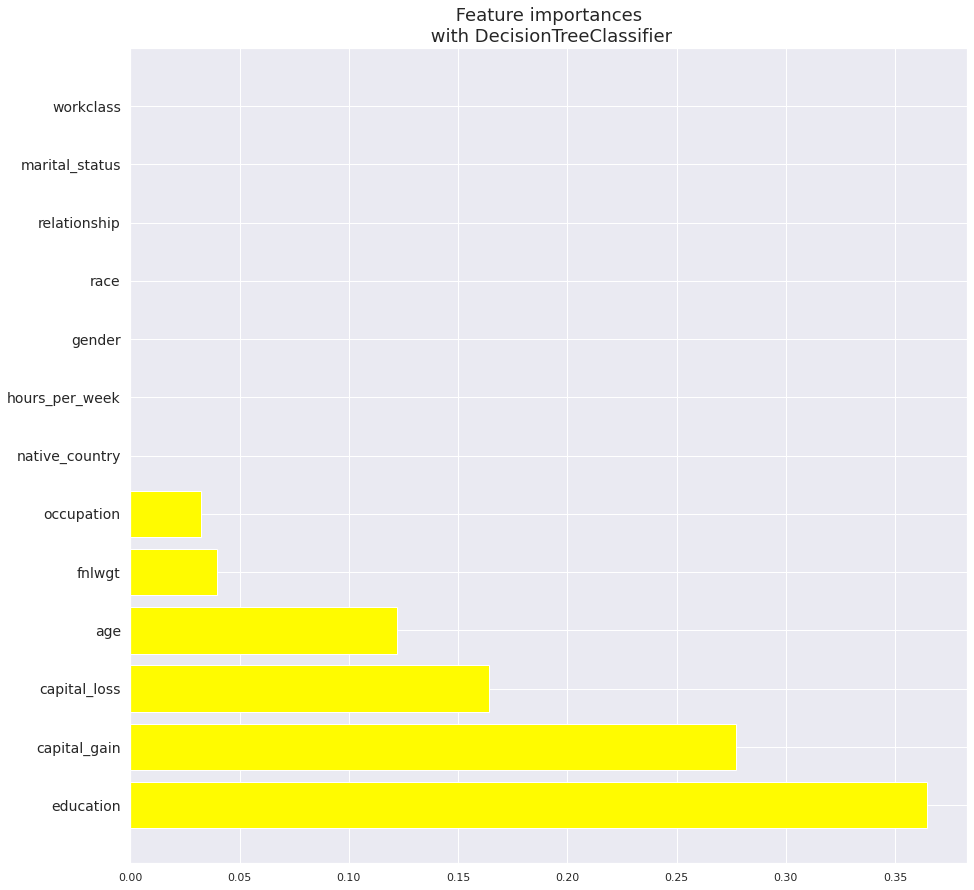

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = adult_df_wife.drop('income', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## Comparison Table

In [ ]:
from tabulate import tabulate
data = [['Husband', husband_accuracy],
['Not_In_Family', notinfamily_accuracy],
['Own_Child', ownchild_accuracy],
['Unmarried', unmarried_accuracy],
['Wife', wife_accuracy]]
print (tabulate(data, headers=["Relationship", "Classification Accuracy"]))

Relationship      Classification Accuracy
--------------  -------------------------
Husband                          0.72058
Not_In_Family                    0.729899
Own_Child                        0.742424
Unmarried                        0.73822
Wife                             0.684859
